In [1]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

# Here Vgg 16 model is implemented , please try with VGG19 too.

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
        
train_path = './Datasets/WhiteHot(Dataset)/Training/'

In [3]:
# Import the VGG16 or VGG19 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [5]:
# useful for getting number of output classes
folders = glob('./Datasets/WhiteHot(Dataset)/Training/*')

In [6]:
len(folders)

2

In [7]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [8]:
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [9]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
# view the structure of the model
model.compile(optimizer='Adamax',  #Adamax , RMSprop , Adagrad, 
              loss='binary_crossentropy',
              metrics=['accuracy','AUC','Precision','Recall'])

print("model compiled")
print(model.summary())

model compiled
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56,

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 50

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.5,1.0],
        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('./Datasets/WhiteHot(Dataset)/Training/',
                                                 target_size = (224, 224),
                                                 batch_size = 50,
                                                 class_mode = 'binary')

test_set = validation_datagen.flow_from_directory('./Datasets/WhiteHot(Dataset)/Testing/',
                                            target_size = (224, 224),
                                            batch_size = 50,
                                            class_mode = 'binary')

Found 1306 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [12]:
len(training_set)

27

In [13]:
training_set.class_indices

{'Fire': 0, 'No_Fire': 1}

In [14]:
imgs ,labels = next(training_set)

In [15]:
from matplotlib import pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

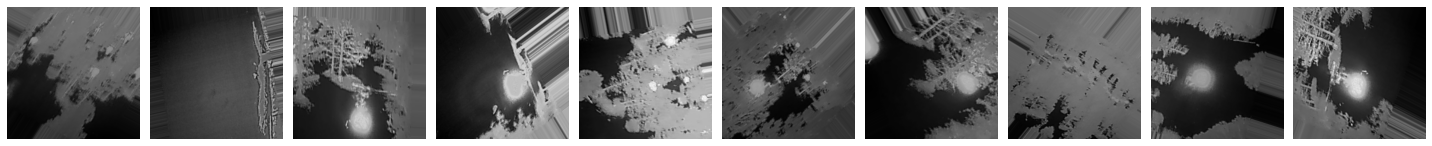

[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0.]


In [16]:
plotImages(imgs)
print(labels)

In [18]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint
#filepath='saved_models/models.h5'
filepath="./FirevsNonFire_vgg16_WH_transfer_learning_model_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
history = model.fit(training_set,
          steps_per_epoch= 1000 // batch_size,
          epochs=10, 
          validation_data=test_set,
          validation_steps= 200 // batch_size,
          callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.7650 - auc: 0.8007 - precision: 0.6824 - recall: 0.3495 
Epoch 00001: val_accuracy improved from -inf to 0.97000, saving model to .\FirevsNonFire_vgg16_WH_transfer_learning_model_weights-improvement-01-0.97.hdf5
20/20 [==============================] - 532s 27s/step - loss: 0.4841 - accuracy: 0.7650 - auc: 0.8007 - precision: 0.6824 - recall: 0.3495 - val_loss: 0.4017 - val_accuracy: 0.9700 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9429
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.9299 - auc: 0.9761 - precision: 0.9356 - recall: 0.8074 
Epoch 00002: val_accuracy improved from 0.97000 to 1.00000, saving model to .\FirevsNonFire_vgg16_WH_transfer_learning_model_weights-improvement-02-1.00.hdf5
20/20 [==============================] - 480s 24s/step - loss: 0.2849 - accuracy: 0.9299 - auc: 0.9761 - precision: 0.9356 - recall: 0.8074 - val_loss

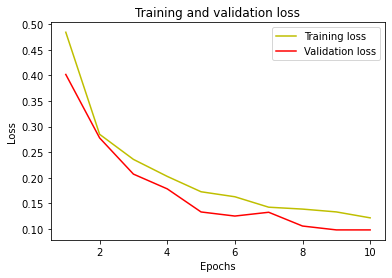

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

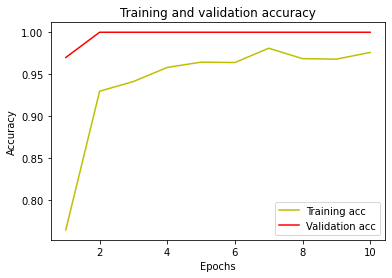

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('FirevsNonFire_Vgg16_transfer_learning_model_weights-improvement.h5')